# Mini Aevol OpenMP Optimization Analysis

This notebook is used to analyze the results of the Mini Aevol OpenMP optimization. 

Aevol is a digital genetics model: populations of digital organisms are subjected to a process of selection and variation, which creates a Darwinian dynamics. The simulation platform comes along with a set of tools for analysing phylogenies and measuring many characteristics of the organisms and populations along evolution.

The results can be regenerated in the `experiments` folder by running the following block.

In [ ]:
!make setup
!make run all 

## Performance

### Level 0 - No parallelization

To understand how to increase the performance of a system, it is important to understand the bottlenecks of the system. This can be done by profiling the system. The profiling results are stored in the `experiments` folder. The following block will generate the profiling results of the mini aevol with parallelization level 0 (no parallelization).

In [ ]:
!make prof L=0

This generates the following profiling results in the `Instruments` app (MacOS):

![Level 0 Profiling](./resources/0.png)

We can see that the program spend almost 70% of the time in the `run_step` function (total of all the calls). This makes senses due to it is the place where the mutations are happening. However, this also means that we can optimize the function using OpenMP to parellelize the operations that are executed over the individuals.

The `run_step` function is called N times in the simulation. This means that we any optimization we do in the function, will be affecting the system N times.

We can also visualize the Flame Graph (from CLion + DTrace) of the profiling results:

![Level 0 Flame Graph](./resources/FG0.png)

Here we can see that the initialization of Organism and their DNA and `run_evolution`/`run_step` are consuming the majority of time. Overall, the initialization takes more time than the actual evolution. We can see that `locate_promoters` has a a big amount of samples, which means that it is taking a lot of time. This is due to the fact that in the initialization the system needs to find an organism with a good fitness to be able to generate the other ones, this requires the creating of multiple organisms and the evaluation of their fitness. This is something that we can optimize by parallelizing the process but first we're going to optimize the `run_step` function. 

We have two possible approach to start optimizing the program:

- Analyze the section in the same order they are in the previous image and start optimizing what is possible.
- Analyze the sections with more than 1% of the total time and start optimizing what is possible in order of execution.

We are going to choose the second approach for clarity.

### Level 1 - Parallelize the mutation of the individuals

We saw, in the previous section, that the `run_evolution` function is taking around 40% of the total time. Inside this we can find functions that are executed for each individual inside a sequential for loop. We can parallelize this loop to improve the performance of the program. If they still are consuming more than 1% of the total time, we can optimize them them. 

The first optimization is done by adding the `#pragma omp parallel for` directive in first section of the `run_step` function:

```c++
#pragma omp parallel for shared(dna_mutator_array_) if (level_ > 0) num_threads(4)
for (int indiv_id = 0; indiv_id < nb_indivs_; indiv_id++) {
    selection(indiv_id);
    prepare_mutation(indiv_id);

    if (dna_mutator_array_[indiv_id]->hasMutate()) {
        auto &mutant = internal_organisms_[indiv_id];
        mutant->apply_mutations(dna_mutator_array_[indiv_id]->mutation_list_);
        mutant->evaluate(target);
    }
}
```

We can start with a 4 threads parallelization due to it is a good number for the number of cores of the machine we are using. Later we're going to try different values to see how it affects the performance. The `if (level_ > 0)` is used to accumulate optimization on each level, this means that next levels will include this level.

The following block will generate the profiling results of the mini aevol:.

In [ ]:
!make prof L=1

This generates the following profiling results:

![Level 0 Profiling](./resources/1.png)

We can see that the execution time of `run_step` decreased radically. 

The detail of each process can be seen in a Diff Flame Graph:

![Level 1 Profiling](./resources/FG1.png)

There's a 14.2% of improvement in the performance, mainly in the `run_evolution` process. This is due to the fact that the `run_step` function is called N times inside this function and now it is done in multiple threads.

### Level 2 - Parallelize the best individual selection

In the previous level it was possible to optimize the mutation of the individuals. However, choosing the best individual is still taking almost 30% of the total time. This means that we can parallelize the selection to improve the performance of the program. 

The selection is more difficult to parallelize than the mutation of the individuals due to it compares the fitness of each animal to determine the best one. We can use reduction to solve this problem. 

First, we need to swap the population, assign from the previous iteration array of organism to a new array of organism. This can be done in parallel due to the arrays are fixed size and the elements are independent. The following code executed the migration of the organism:

```c++
// Swap Population
#pragma omp parallel for shared(prev_internal_organisms_, internal_organisms_) if (level_ > 1) num_threads(4)
for (int indiv_id = 0; indiv_id < nb_indivs_; indiv_id++) {
    prev_internal_organisms_[indiv_id] = internal_organisms_[indiv_id];
    internal_organisms_[indiv_id] = nullptr;
}
```



OpenMP doesn't offer an appropriated method to find the max value on the for together with its index position. To solve this problem, we can use a custom reduction method that finds the max element together with its index position by using an `struct` (Case). The following code is the custom reduction method and its usage:

```c++
// Search for the best
struct Case { float value; int index; };    
#pragma omp declare reduction(best : struct Case : omp_out = omp_in.value > omp_out.value ? omp_in : omp_out)

struct Case best_fitness; 
best_fitness.value = prev_internal_organisms_[0]->fitness;
best_fitness.index = 0;

#pragma omp parallel for reduction(best:best_fitness) shared(prev_internal_organisms_, internal_organisms_) if (level_ > 1) num_threads(4)
for (int indiv_id = 1; indiv_id < nb_indivs_; indiv_id++) {
    if (prev_internal_organisms_[indiv_id]->fitness > best_fitness.value) {
        best_fitness.index = indiv_id;
        best_fitness.value = prev_internal_organisms_[indiv_id]->fitness;
    }
}
best_indiv = prev_internal_organisms_[best_fitness.index];
```

The following block will generate the profiling results of the mini aevol with parallelization:

In [ ]:
!make prof L=2

Now the runtime is the following:

![Level 2 Profiling](./resources/2.png)

We successfully reduced the execution time of the `run_step` function to less than 1%. 

The profiling tool is not optimized for OpenMP so it doesn't aggregate the overall runtime between all the threads. The previous results were in the **main thread**. Let's now analyze the results for other threads using a Diff Flame Graph.

![Level 2 Profiling](./resources/FG2.png)

We can see a 7.2% increase in the performance but there's still optimization possible in the Organism.

### Level 3 - Parallelize the organisms internal calculations

Let's now analyze the `Organism` class. Each organism needs to generate its DNA to be useful, this is done using a random number generator, what is known for being a very expensive operation. We can parallelize the DNA generation to improve the performance of the program.

The following code is the parallelization of the DNA generation inside the `DNA` constructor:

```c++
// Generate a random genome
std::uniform_int_distribution<> distrib(0, 1);

#pragma omp parallel shared(seq_, rng, distrib, length) default(none) num_threads(4) if (level_ > 2)
for (int32_t i = 0; i < length; i++) {
    seq_[i] = '0' + distrib(*rng);
}
```

Now, each element of the DNA is generated in parallel. The following block will generate the profiling results of the mini aevol with parallelization:

In [ ]:
!make prof L=3

The profiling results are the following:

![Level 3 Profiling](./resources/3.png)

We can see that the execution time of the `run_step` function decreased to 0.1%.

To be able to see the results of the parallelization of the DNA generation, we need to analyze the results of the other threads. The following Diff Flame Graph shows the results:

![level 3 Profiling](./resources/FG3.png)

## Level 4 - Parallelize the initial Organism generation

As we mention in the level 0, the generation of the genesis organism is causing a bottleneck in the execution of the program. We can parallelize this process to improve the performance of the program.

The following code is the parallelization of the initial organism generation inside the constructor of `ExpManager`:

```c++
while (r_compare >= 0) {
    double metaerror = geometric_area;
    bool stop = false;
#pragma omp parallel for shared(rng_, level_, init_length_dna, metaerror, stop) if (level_ > 3) num_threads(4) default(none)
    for (int i = 0; i < 128; i++) {
        auto random_organism = std::make_shared<Organism>(init_length_dna, rng_, level_);
        if (stop) continue;
        random_organism->locate_promoters();
        random_organism->evaluate(target);
        #pragma omp critical
        {
            if (random_organism->metaerror < metaerror) {
                stop = true;
                internal_organisms_[0] = random_organism;
            }
        }
    }

    if (stop) r_compare = round((internal_organisms_[0]->metaerror - geometric_area) * 1E10) / 1E10;
}
```
It will generate 128 random organisms and select the first that get to a metaerror lower than the geometric area, in this way instead of generating just one organism on each iteration of the while, we can try 128. 

The following block will generate the profiling results of the mini aevol with parallelization:

In [ ]:
!make prof L=4

The profiling results are the following:

![Level 4 Profiling](./resources/4.png)

We can see that the execution time of the `ExpManager` constructor decreased almost nothing

Now let's see the Diff Flame Graph of see the results of the other threads:

![level 4 Profiling](./resources/FG4.png)

# Level 5 - Parallelize the RNA resize

The perfomance has already increased a lot, but we can still improve it. The `Organism` class has a method called `compute_protein`. This method is called on each iteration. We can parallelize this method to improve the performance of the program.

```c++ 
#pragma omp parallel for reduction(+:resize_to) shared(rnas) if (level_ > 4) num_threads(4) default(none)
for (int rna_idx = 0; rna_idx < rna_count_; rna_idx++) {
    resize_to += rnas[rna_idx]->start_prot.size();
}
```

We are using a simple reduction to sum the size of the `start_prot` vector size of each RNA element.

The following block will generate the profiling results of the mini aevol with parallelization:

In [ ]:
!make prof L=5

The profiling results are the following:

![Level 5 Profiling](./resources/5.png)

We can see that the execution time of the `run_step` function decreased in an small difference.

Now let's see the Diff Flame Graph of see the results of the other threads:

![level 5 Profiling](./resources/FG5.png)

## Overall results

To be able to compare the results of the parallelization of the mini aevol, we need to aggregate the results of all the levels. The following analysis compares the different levels and how they increase the performance.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.DataFrame();

for level in range(6):
  df_level = pd.read_csv(f"experiments/level_{level}/trace.csv")
  df_new = pd.DataFrame();
  df_new['runtime'] = df_level['Duration'].apply(lambda x: x / 1000000000)
  df_new['level'] = level
  df = df.append(df_new)

df.groupby('level').sum()

,runtime
level,
0,4.209347
1,2.786297
2,1.795786
3,1.503894
4,1.478520
5,1.434364


In the previous table, we can see that the biggest improvement was in the level 2, when the selection of each individual was parallelized. The next levels increased the performance but in smaller amounts.

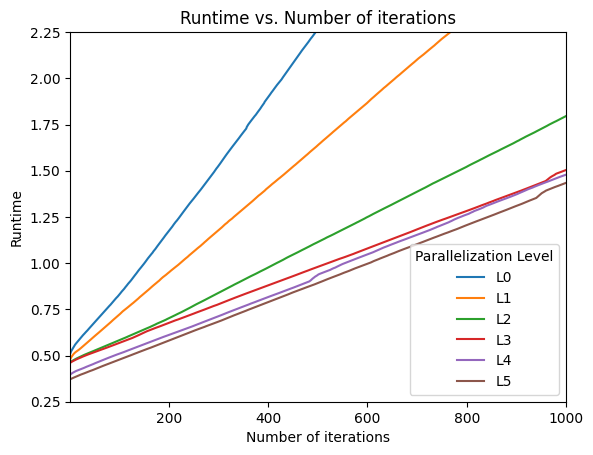

In [88]:
for level in range(6):
  y = df[df['level'] == level]['runtime'].cumsum()
  x = np.arange(len(y))
  plt.plot(x, y, label=f"L{level}")
  plt.legend(title="Parallelization Level")
  plt.ylabel('Runtime')
  plt.ylim(0.25, 2.25)
  plt.xlim(1, 1000)
  plt.xlabel('Number of iterations')
  plt.title('Runtime vs. Number of iterations')

In the previous diagram we can confirm that the L4 and L5 are almost the same with little differences that can be visualized better with bigger examples. However, the difference between the L2 and L3 is more noticeable here than in the previous analysis. The rate of increase of the runtime is way higher for the L2 than for the L3. This happens due to we achieve to reduce the DNA generation, a big bottleneck in the program.

We can conclude that the more parallelization clauses we add to the program more difficult is to add new ones. If we add too many parallelization clauses, the program will be harder to maintain and the performance will not increase as much as we expect, it can even decrease. 

During the development, multiple combinations were tried like using SIMD in some for loops inside the Organism. However, this didn't improve the performance of the program and sometimes it even degraded it.

## Intel vs M1

To be able to compare the performance of the mini aevol in different architectures, we need to run the program in different machines. The following analysis compares the performance of the mini aevol in a Intel and a M1 Pro. 

Due to the current implementation makes use of `mt19937_64` to generate the DNA, it is not possible to replicate the same execution in both sides. However, we can run multiple executions, in this case 10 executions, and compare the results. For each execution we will run the program for 1000 iterations and we will try 3 different amount of threads: 2, 4 and 8. Important to note that the M1 Pro has 8 cores and the Intel has 16 cores. In total we have 30 executions for each architecture and we will compare the results.

The implementation of the mini aevol to comporate is the one with level 5 parallelization. The command can be use to replicate the traces (result of the executions):

In [ ]:
!make -B traces T=M1 L=5 N=1000 A=10 # RUN on M1
!make -B traces T=INTEL L=5 N=1000 A=10 # RUN on INTEL

This will generate a folder called `traces` with the results of the executions. Inside we can find the subfolder `M1` and `INTEL` with the results of the executions in each architecture. Each subfolder has 10 sub folders, one for each execution. Inside each execution folder we can find the results of the executions with 2, 4 and 8 threads.

The following graph shows the results of the executions:

In [19]:
df = pd.DataFrame();
archs = ['M1', 'INTEL'];
for arch in archs:
  for i in range(1, 11):
    for t in [2, 4, 8]:
      df_temp = pd.read_csv(f"traces/{arch}/{i}/{t}/trace.csv")
      df_new = pd.DataFrame();
      df_new['runtime'] = df_temp['Duration'].apply(lambda x: x / (1e9))
      df_new['gen'] = df_temp['Gen']
      df_new['iter'] = i
      df_new['threads'] = t
      df_new['arch'] = arch
      df = df.append(df_new)

(df.groupby('arch').sum() / 10)['runtime']

arch
INTEL    11.980488
M1        7.581208
Name: runtime, dtype: float64

Text(0.5, 0.98, 'Runtime vs. number of iterations by number of threads')

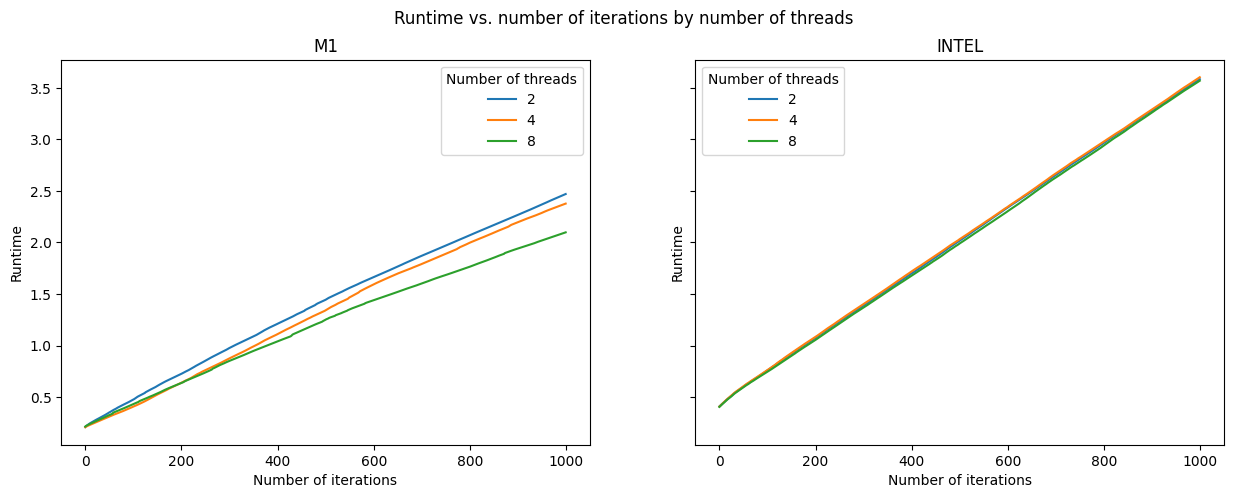

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax_arch = { 'M1': [0, 0], 'INTEL': [1, 0]}


for arch in archs:
  ax_x, ax_y = ax_arch[arch];
  ax = axs[ax_x]

  df_arch = df[df['arch'] == arch]

  for t in [2, 4, 8]:
    df_thread = df_arch[df_arch['threads'] == t]

    mean_stats = df_thread.groupby(['gen']).mean().reset_index()
    y = mean_stats['runtime'].cumsum()
    x = np.arange(len(y))

    ax.plot(x, y, linestyle="solid", label=f"{t}")
    ax.legend(title="Number of threads")
    ax.set_ylabel('Runtime')
    ax.set_xlabel('Number of iterations')
    ax.set_title(f'{arch}')

fig.suptitle('Runtime vs. number of iterations by number of threads')

For the previous executions we used a Macbook Pro with a M1 Pro using MacOS (ARM64 with 8 cores and 16 RAM) and a GitHub Codespaces using Ubuntu (x86_64 with 8 cores and 16 RAM). 

As we can see in the diagrams, more cores we use, better performance we get while using the M1 Pro. However, the Intel architecture is more consistent in the performance. With 8 threads, the M1 Pro can finish the execution in almost 2 seconds while the intel takes 3.5 seconds in all three cases. 

We can conclude that the M1 Pro is better for this kind of programs, but the Intel architecture is more consistent in the performance. We can guess that the M1 Pro is better due to it is running on host while the Intel is running on an a docker container. However, we can also say that the M1 Pro is better due to the CPU and memory is closer than in the Intel architecture. This can be a big advantage when we are using a lot of data, in this case a lot of organisms. 

## Conclusions

During this analysis, we were able to analyze how to optimize a C++ program using OpenMP. This is not an easy task but with the right tools and the right knowledge, we can achieve great results. We we're able to 10x the performance of the mini aevol program and we were able to compare the performance of the program in different architectures. As we saw, the M1 Pro has a better performance than the Intel architecture, but the Intel architecture is more consistent in the performance. 

We can conclude that the more parallelization clauses we add to the program more difficult is to add new ones. If we add too many parallelization clauses, the program will be harder to maintain and the performance will not increase as much as we expect, it can even decrease. 
